In [1]:
#Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 500

# Part 1: Extracting the data

In [33]:
a = '/home/rakshith/Desktop/hus_Amon_MIROC6_historical_r1i1p1f1_gn_201001-201412.nc'
b = '/media/rakshith/Seagate Expansion Drive/Good models/MIROC6/prw_Amon_MIROC6_historical_r1i1p1f1_gn_185001-201412.nc'
ds1 = xr.open_dataset(a)
ds2 = xr.open_dataset(b) #Loading the datasets in netCDF format

In [34]:
sh = ds1.sel(lat=slice(10,30), lon=slice(70,90)).mean(dim=['lat', 'lon'])
#Extracting data only for India with latitude 10-30N and longitude 70-90E

In [35]:
for i in range(12):
    print('\nMonth',i+1)
    for j in range(len(sh.plev)):
        print(sh.hus[i,j].values) #Printing specific humidity values for each month in 2010


Month 1
0.009524256
0.006350666
0.004637116
0.002094466
0.0010376371
0.00055216486
0.00038411387
0.00019449701
9.317225e-05
3.3806606e-05
6.323809e-06
1.5635004e-06
1.69546e-06
1.8946042e-06
1.7649334e-06
1.8441459e-06
2.355052e-06
2.7178476e-06
3.227633e-06

Month 2
0.011294778
0.0058545643
0.004421936
0.0024839877
0.0009751456
0.00040379507
0.00022260968
9.516938e-05
4.8224727e-05
2.1664135e-05
5.706641e-06
1.689668e-06
1.5686524e-06
1.8726715e-06
1.8759685e-06
1.8589043e-06
2.373033e-06
2.7182805e-06
3.1823824e-06

Month 3
0.013060852
0.006986905
0.0049597444
0.003456871
0.0018980281
0.00059105095
0.0002437803
0.00010070934
4.6841134e-05
1.6129194e-05
4.3959985e-06
1.5660208e-06
1.4766548e-06
1.8337054e-06
1.85588e-06
1.8505234e-06
2.5535433e-06
2.6916944e-06
3.1829136e-06

Month 4
0.015932903
0.01032913
0.007547912
0.005227988
0.003262456
0.0014489787
0.0006192389
0.0002265306
9.7003416e-05
2.94269e-05
5.7801594e-06
1.4218908e-06
1.3461736e-06
1.7474415e-06
1.8893733e-06
1.8946611

In [36]:
pwat = ds2.sel(time='2010', lat=slice(10,30), lon=slice(70,90)).mean(dim=['lat', 'lon'])
tcwv = pwat.prw.values
#Water vapour (observed) value for the same region and same year

# Part 2: Interpolation

In [37]:
df = pd.read_excel('Project.xlsx', skiprows=1).dropna(how='all', axis=1)
data = df.dropna() 
data = data[:-1]

In [38]:
from typing import Tuple, List
import bisect

#We use Cubic Spline interpolation here which avoids the problem of runge's phenomenon

def compute_changes(x: List[float]) -> List[float]:  #function to compute differences between consecutive values
    return [x[i+1] - x[i] for i in range(len(x) - 1)]

def create_tridiagonalmatrix(n: int, h: List[float]) -> Tuple[List[float], List[float], List[float]]:
    #fuction to create a tridiagonal matrix which has nonzero elements only on the main diagonal, the lower diagonaland the upper diagonal 
    A = [h[i] / (h[i] + h[i + 1]) for i in range(n - 2)] + [0]   
    B = [2] * n
    C = [0] + [h[i + 1] / (h[i] + h[i + 1]) for i in range(n - 2)]
    
    # defining arrays: B of n length array holding the diagonal elements, A of n-1 length array of the diagonal above this and 
    # C to be the n-1 length array of the diagonal below this
    return A, B, C

def create_target(n: int, h: List[float], y: List[float]):
    #Defining the Right hand side of the tridiagonal system equation
    return [0] + [6 * ((y[i + 1] - y[i]) / h[i] - (y[i] - y[i - 1]) / h[i - 1]) / (h[i] + h[i-1]) for i in range(1, n - 1)] + [0]

def solve_tridiagonalsystem(A: List[float], B: List[float], C: List[float], D: List[float]):
    #To solve the tridiagonal system, we use Thomas algorithm and define new primed coefficients c_p and d_p (check wikipedia)
    c_p = C + [0]
    d_p = [0] * len(B)
    X = [0] * len(B)

    c_p[0] = C[0] / B[0]
    d_p[0] = D[0] / B[0]
    for i in range(1, len(B)):
        c_p[i] = c_p[i] / (B[i] - c_p[i - 1] * A[i - 1])
        d_p[i] = (D[i] - d_p[i - 1] * A[i - 1]) / (B[i] - c_p[i - 1] * A[i - 1])

    X[-1] = d_p[-1]
    for i in range(len(B) - 2, -1, -1):
        X[i] = d_p[i] - c_p[i] * X[i + 1]  #using these new coefficients, we back substitute to get x.
        

    return X

def compute_spline(x: List[float], y: List[float]):
    # final step:  to convert all this into a set of cubic curves
    n = len(x)
    if n < 3:
        raise ValueError('Too short an array')
    if n != len(y):
        raise ValueError('Array lengths are different')
    #Using the above defined functions here
    h = compute_changes(x)
    if any(v < 0 for v in h):
        raise ValueError('X must be strictly increasing')

    A, B, C = create_tridiagonalmatrix(n, h)
    D = create_target(n, h, y)

    M = solve_tridiagonalsystem(A, B, C, D)

    coefficients = [[(M[i+1]-M[i])*h[i]*h[i]/6, M[i]*h[i]*h[i]/2, (y[i+1] - y[i] - (M[i+1]+2*M[i])*h[i]*h[i]/6), y[i]] for i in range(n-1)]

    def spline(val):
        idx = min(bisect.bisect(x, val)-1, n-2) #Python's bisect does a binary search to find the index easily and quickly.
        z = (val - x[idx]) / h[idx]
        C = coefficients[idx]
        return (((C[0] * z) + C[1]) * z + C[2]) * z + C[3]

    return spline #the final spline function which helps us evaluate y for any x.

# Part 3: Integration

In [1]:
x = data['Month/ Pressure level'].values
x_new = np.arange(1, 1000,2)
y_new = []
y_final = []
x_final = np.linspace(1,12,12)
for i in range(1,13):
    I = 0
    y = np.array(data.iloc[:, i])#storing dataset of each month in an array
    f = compute_spline(x[::-1],y[::-1])#calculating interpolation function for each month
    for j in range(len(x_new)):
        y_new.append(f(x_new[j]))
        for k in range(len(y_new)-1):
            I += 2*(y_new[k+1]-y_new[k])#integration
    y_final.append(I)
y_final = 100/ 9.80616*np.array(y_final)#Final Water vapour array to be plotted

NameError: name 'data' is not defined

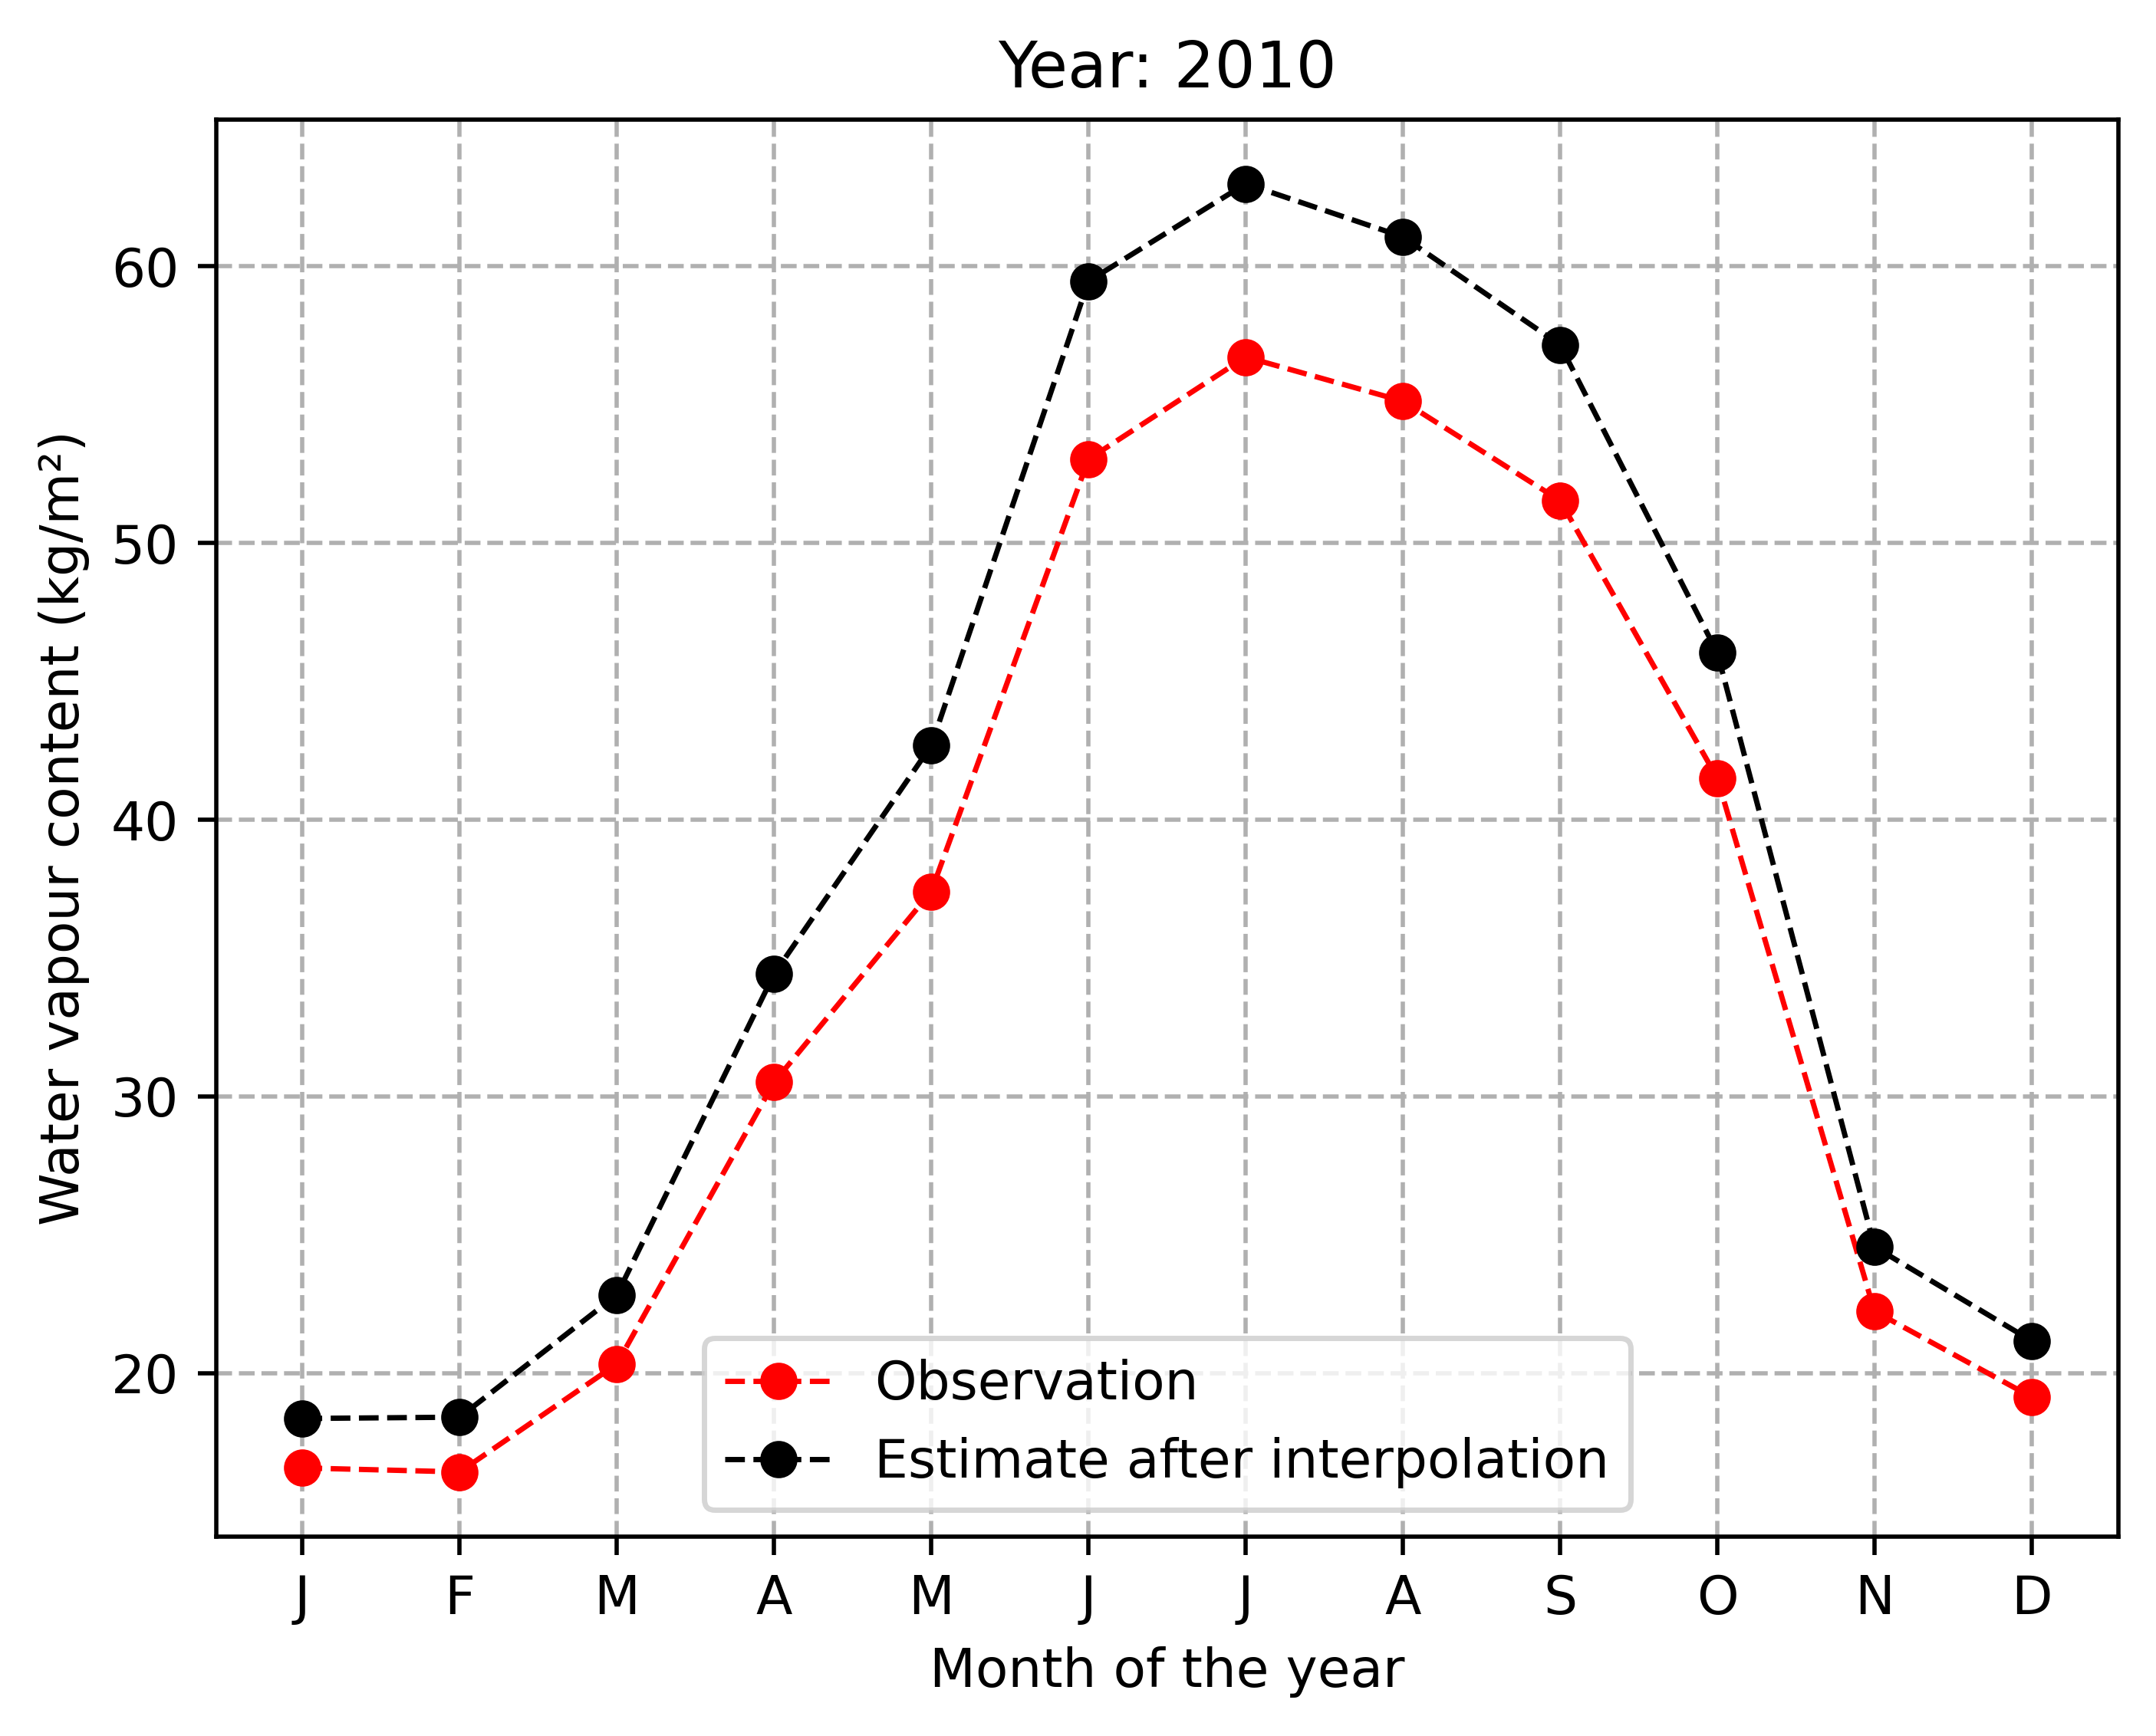

In [40]:
X = np.arange(1, 13, 1)
mon = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'] #Months

plt.plot(X, tcwv, label='Observation', c='r', linestyle='--', marker='o', linewidth=1) #Observations plot
plt.plot(x_final, y_final, label='Estimate after interpolation', c='black', linestyle='--', marker='o', linewidth=1)
#Calculated water vapour plot
plt.xlabel('Month of the year')
plt.ylabel('Water vapour content (kg/m\u00b2)')
plt.xticks(X, mon)
plt.grid(linestyle='--')
plt.title('Year: 2010')
plt.legend()

# Error Calculation

In [41]:
print('The percentage error is: ', np.average(np.divide(y_final-tcwv, tcwv))*100)

The percentage error is:  11.572499068413068


In [42]:
def lagrange_interpolant(x, f):
    N = len(x)
    a = np.ones(N)
    for i in range(N):
        for j in range(N):
            if i != j:
                a[i] *= 1/(x[i] - x[j])
    def p(x_):
        result = 0.
        for i in range(N):
            term_i = a[i] * f[i]
            for j in range(N):
                if i != j:
                    term_i *= x_ - x[j]
            result += term_i
        return result
    
    return p

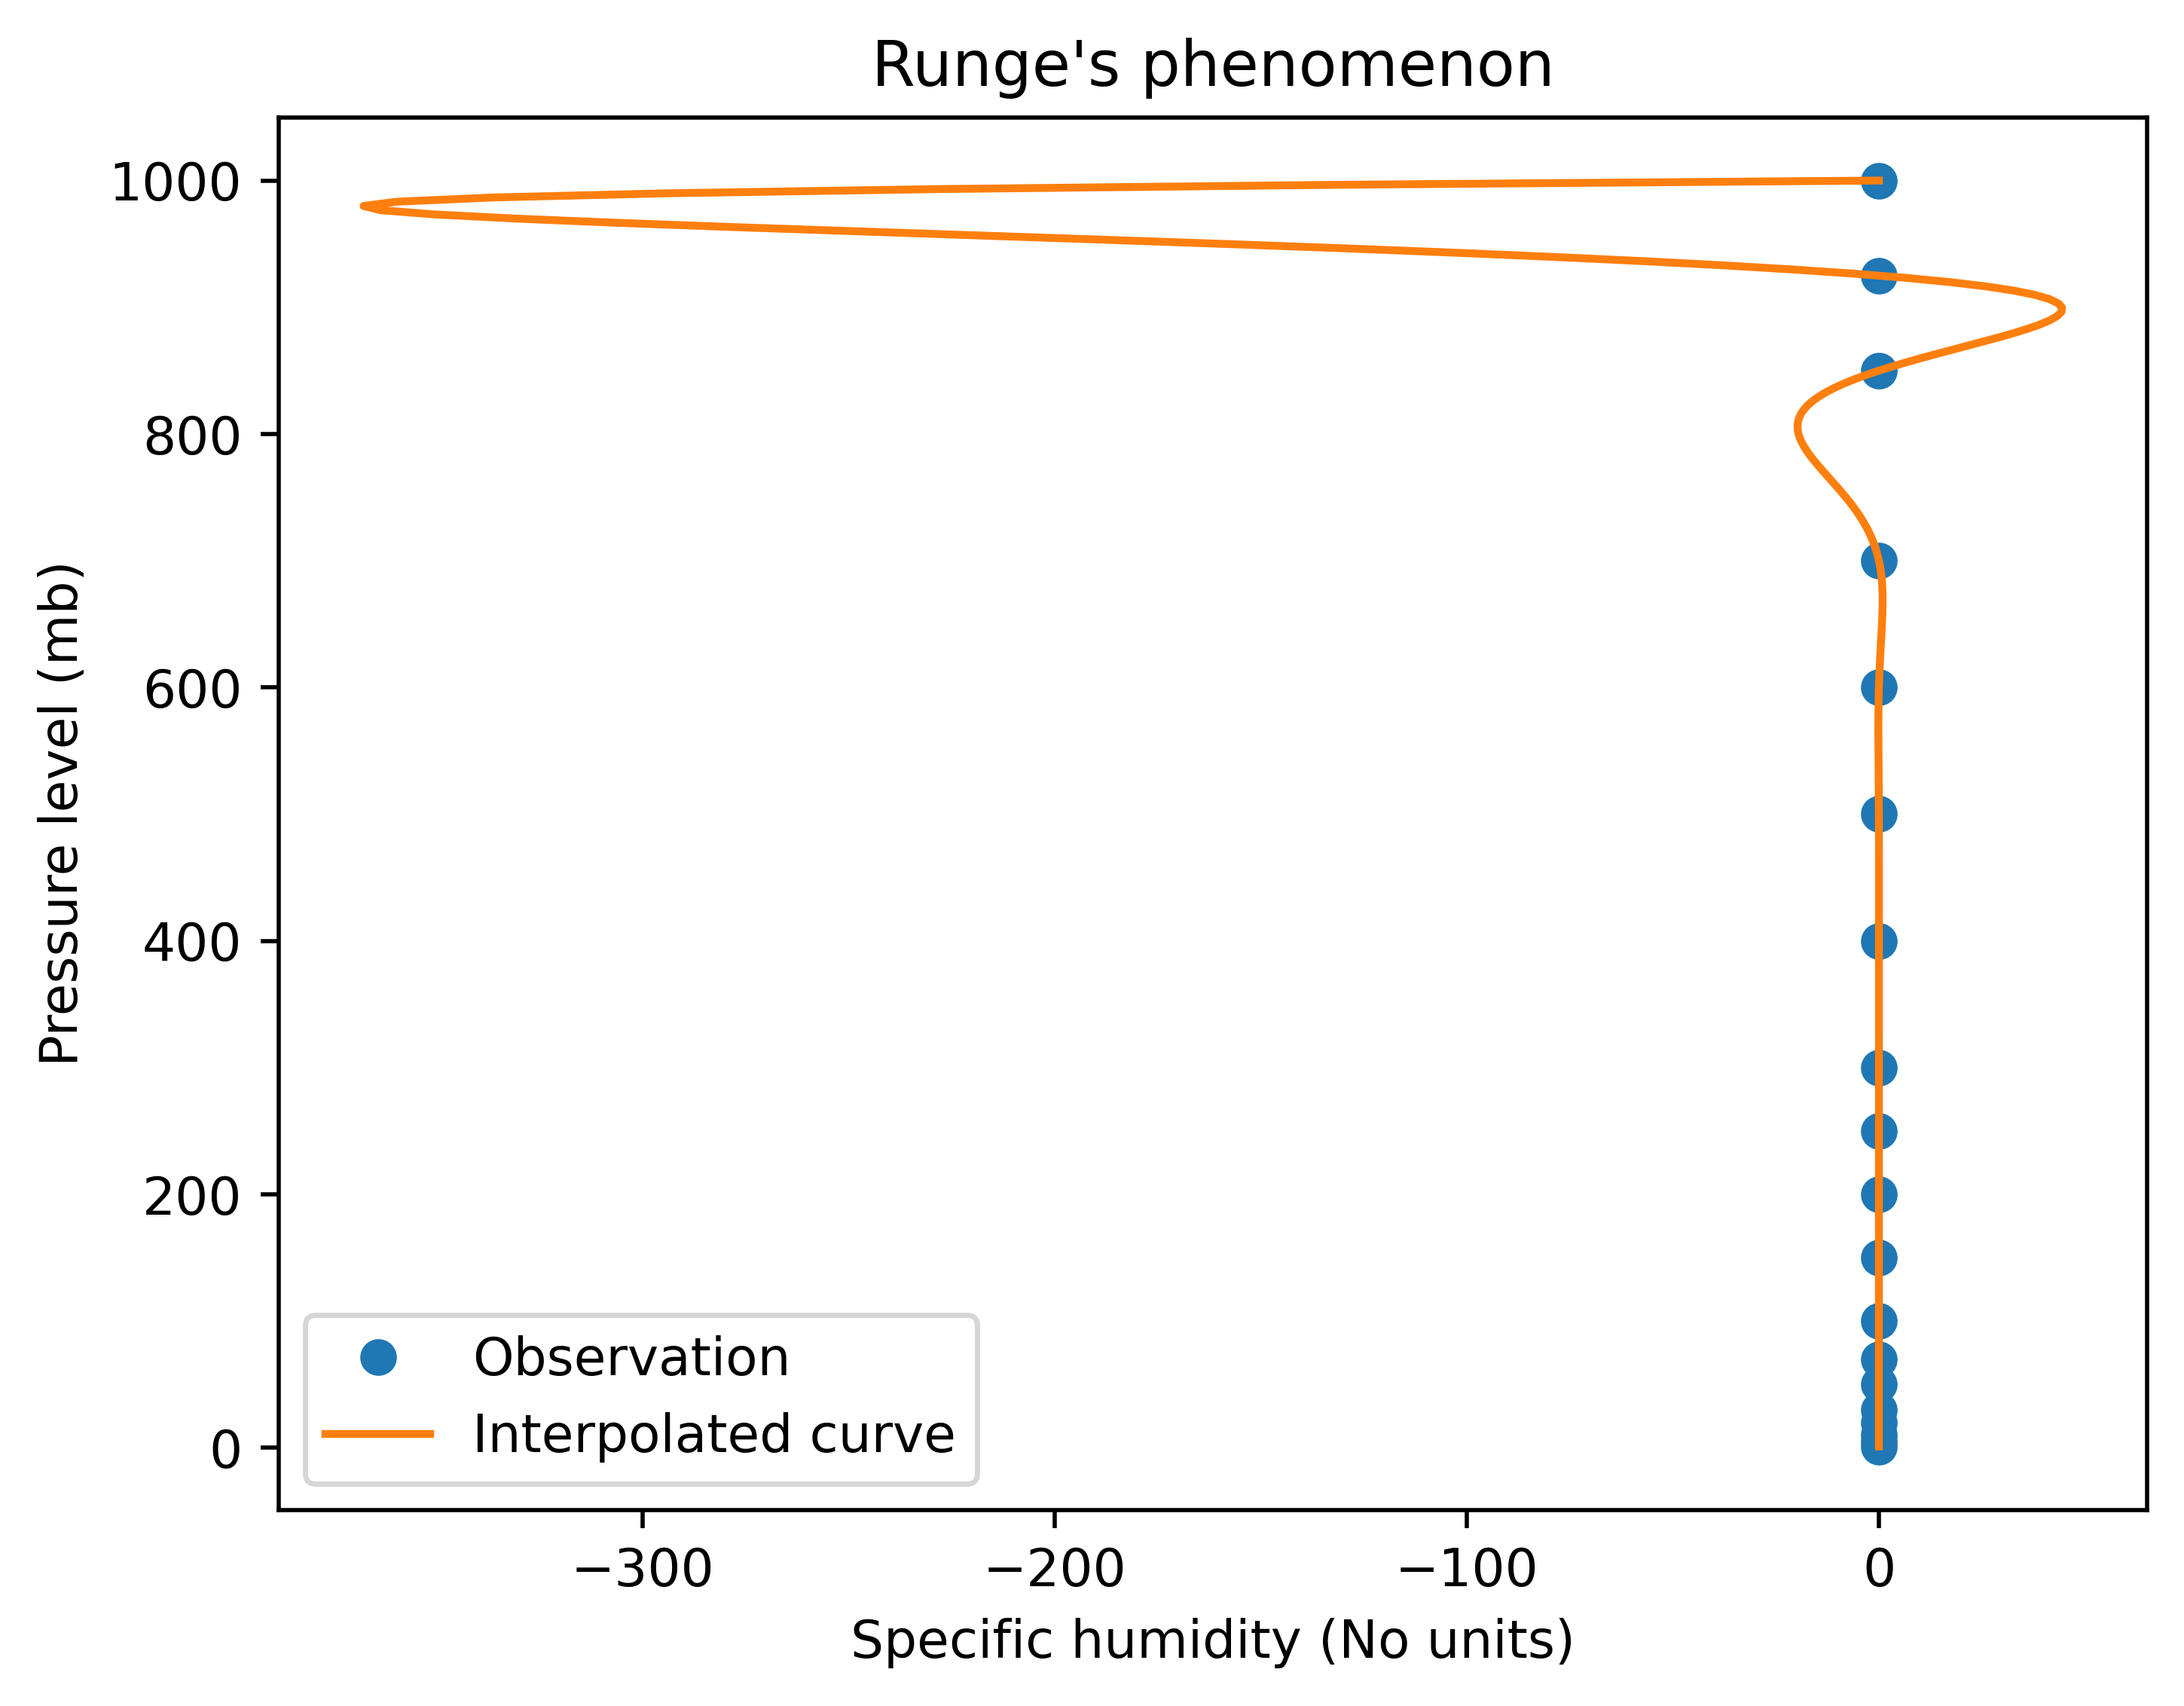

In [43]:
plt.plot(y,x,'o', label='Observation')
xx = np.linspace(min(x), max(x), 300)
f_inter = lagrange_interpolant(x, y)
plt.plot(f_inter(xx), xx, label='Interpolated curve')
plt.ylabel('Pressure level (mb)')
plt.xlabel('Specific humidity (No units)')
plt.title("Runge's phenomenon")
plt.legend()